# 0.0 IMPORTS

In [1]:
import inflection
import math
import datetime
import warnings
import pickle
import seaborn                          as sns
import pandas                           as pd
import numpy                            as np
import matplotlib.pyplot                as plt
# import xgboost                          as xgb

from scipy                 import stats as ss
from IPython.display       import Image
from tabulate              import tabulate

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.4f}".format

In [94]:
def day_period(hora):
    if datetime.datetime.strptime("00:00:00", "%H:%M:%S").time() <= hora.time() <= datetime.datetime.strptime("05:59:59", "%H:%M:%S").time():
        return "dawn"
    elif datetime.datetime.strptime("06:00:00", "%H:%M:%S").time() <= hora.time() <= datetime.datetime.strptime("11:59:59", "%H:%M:%S").time():
        return "morning"
    elif datetime.datetime.strptime("12:00:00", "%H:%M:%S").time() <= hora.time() <= datetime.datetime.strptime("17:59:59", "%H:%M:%S").time():
        return "afternoon"
    else:
        return "night"

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# Model Avaliation 
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) ) 
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )

# Cross Validation
def cross_validation( x_training, kfold, model_name, model, verbose=False):

    mae_list= []
    mape_list= []
    rmse_list= []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print('\nKFold Number: ', k)
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame( {
            'Model Name': model_name,
            'MAE CV': np.round( np.mean(mae_list), 2 ).astype(str) + " +/- " + np.round( np.std(mae_list), 2 ).astype(str),
            'MAPE CV': np.round( np.mean(mape_list), 2 ).astype(str) + " +/- " + np.round( np.std(mape_list), 2 ).astype(str),
            'RMSE CV': np.round( np.mean(rmse_list), 2 ).astype(str) + " +/- " + np.round( np.std(rmse_list), 2 ).astype(str)
        }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( (y-yhat) / y )

## 0.2 Loading Data

In [4]:
path_data = "../data/raw/"
file = "train.csv"

# CSV
df_raw = pd.read_csv(path_data + file, low_memory=False)
# df_raw1 = pd.read_csv(path_data + 'weather_station_to_county_mapping.csv', low_memory=False)

In [5]:
# from shapely.geometry import Point, Polygon

# # Lista de coordenadas
# coordenadas = [(58.314502, 26.567954), (58.601123, 22.255536), (59.4370, 24.7536)]  # Substitua com suas próprias coordenadas

# # Lista de polígonos representando as regiões da Estônia
# # Exemplo: Tallinn e Tartu
# poligonos_estonia = [
#     Polygon([(57.909241,22.045001),(58.091748,22.247803),(58.448296,23.325354),(58.671462,22.778424),(58.494723,21.846066),(58.279932,21.835808),(58.158267,22.214486),(57.976952,21.987249)]), # Saaremaa
#     Polygon([(58.930614,21.995549),(59.117489,22.678813),(58.839034,23.121406),(58.669885,22.570639)]), # Hiiumaa
#     Polygon([(57.875688,24.386377),(58.731684,23.463538),(58.704998,25.301642),(58.333100,24.967435),(58.260484,25.264555),(58.030627,25.033266)]), # Pärnumaa
#     Polygon([(58.716885,24.029207),(58.771290,23.140566),(59.228776,23.077535),(59.250348,23.694357),(59.055735,24.161490)]), # Läänemaa
#     Polygon([(58.699250,24.133020),(58.987323,24.091950),(59.213355,24.630636),(59.221882,24.900632),(58.991191,25.322495),(58.664665,24.924818)]), # Raplamaa
#     Polygon([(58.999688,24.292102),(59.232012,24.913743),(58.991818,25.324184),(59.271184,25.463257),(59.276531,25.950252),(59.723009,25.721541),(59.466326,23.416765)]), # Harjumaa
#     Polygon([(58.045542,25.036610),(58.275094,25.279122),(58.328075,24.983104),(58.500729,25.036562),(58.687336,25.782312),(58.413488,26.187120),(58.097451,26.068628),(57.965990,25.599092)]), # Viljandimaa
#     Polygon([(58.731859,25.060221),(58.936718,25.118759),(59.266086,25.476517),(59.184949,26.003151),(58.838645,26.128648),(58.620218,25.259202)]), # Järvamaa
#     Polygon([(57.582152,26.477133),(57.756954,25.987071),(57.943257,25.585645),(58.149589,25.859783),(58.026949,26.123447),(58.162721,26.550464),(57.962221,26.577496),(57.933519,26.384930)]), # Valgamaa
#     Polygon([(58.475713,26.142790),(58.862400,27.366270),(59.068785,26.899842),(58.692384,25.783614)]), # Jõgevamaa
#     Polygon([(58.984867,26.791644),(59.614951,26.999953),(59.716053,25.726455),(59.276040,25.956887),(59.256570,25.538514),(59.185595,26.011746),(58.896017,26.145833)]), # Lääne-Virumaa
#     Polygon([(57.936111,26.411170),(57.474713,26.534274),(57.699885,28.003695),(58.097359,27.556545)]), # Võrumaa
#     Polygon([(58.178293,26.659231),(58.297622,27.450937),(58.092661,27.592132),(57.933223,26.627291)]), # Põlvamaa
#     Polygon([(58.978170,26.659231),(59.594875,26.587502),(59.496868,28.427515),(58.956872,27.855354)]), # Ida-Virumaa
# ]

# # Verificar se as coordenadas estão dentro de alguma região
# for coord in coordenadas:
#     ponto = Point(coord[0], coord[1])
#     dentro_da_regiao = False

#     for poligono in poligonos_estonia:
#         if ponto.within(poligono):
#             dentro_da_regiao = True
#             break

#     if dentro_da_regiao:
#         print(f"Coordenada {coord} está dentro de uma região da Estônia.")
#     else:
#         print(f"Coordenada {coord} não está dentro de uma região da Estônia.")


# 1.0 DATA DESCRIPTIONS

In [72]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [73]:
print( 'Number of Rows: {}'.format(df1.shape[0]) )
print( 'Number of Columns: {}'.format(df1.shape[1]) )

Number of Rows: 2018352
Number of Columns: 9


## 1.2 Data Types

In [74]:
df1.dtypes

county                  int64
is_business             int64
product_type            int64
target                float64
is_consumption          int64
datetime               object
data_block_id           int64
row_id                  int64
prediction_unit_id      int64
dtype: object

## 1.3 Change Data Types

In [75]:
df1['datetime'] = df1['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df1.dtypes

county                         int64
is_business                    int64
product_type                   int64
target                       float64
is_consumption                 int64
datetime              datetime64[ns]
data_block_id                  int64
row_id                         int64
prediction_unit_id             int64
dtype: object

## 1.4 Check NA

In [76]:
df1.isna().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

## 1.5 Descriptive Statistical

In [77]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1 Numerical Attributes

In [78]:
# Alternative Code
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,mean,median,std,min,max,skew,kurtosis
0,county,7.2970,7.0000,4.7810,0.0000,15.0000,0.0234,-1.2282
1,is_business,0.5368,1.0000,0.4986,0.0000,1.0000,-0.1477,-1.9782
2,product_type,1.8989,2.0000,1.0818,0.0000,3.0000,-0.1992,-1.5245
3,target,274.8556,31.1330,909.5024,0.0000,"15,480.2740",7.6761,73.3034
4,is_consumption,0.5000,0.5000,0.5000,0.0000,1.0000,0.0000,-2.0000
5,data_block_id,321.8746,323.0000,182.6343,0.0000,637.0000,-0.0189,-1.1823
6,row_id,"1,009,175.5000","1,009,175.5000","582,648.1796",0.0000,"2,018,351.0000",-0.0000,-1.2000
7,prediction_unit_id,33.0454,33.0000,19.5906,0.0000,68.0000,0.0190,-1.2110


### 1.5.2 Categorical Attributes

In [79]:
print('Valor minimo:', format(df1['datetime'].min()))
print('Valor maximo:', format(df1['datetime'].max()))

Valor minimo: 2021-09-01 00:00:00
Valor maximo: 2023-05-31 23:00:00


# 2.0 FEATURE ENGINEERING

In [80]:
df2 = df1.copy()

## 2.4 - Feature Engineering

In [81]:
df2.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.7130,0,2021-09-01,0,0,0
1,0,0,1,96.5900,1,2021-09-01,0,1,0
2,0,0,2,0.0000,0,2021-09-01,0,2,1
3,0,0,2,17.3140,1,2021-09-01,0,3,1
4,0,0,3,2.9040,0,2021-09-01,0,4,2


In [96]:
# year
df2['year'] = df2['datetime'].dt.year

# month
df2['month'] = df2['datetime'].dt.month

# day
df2['day'] = df2['datetime'].dt.day

# week of year
df2['week_of_year'] = df2['datetime'].dt.isocalendar().week

# year week
df2['year_week'] = df2['datetime'].dt.strftime( '%Y-%W' )

# year month
df2['year_month'] = df2['datetime'].dt.strftime( '%H-%m' )

# day period 
df2['day_period'] = df2['datetime'].apply(day_period)

# 3.0 DATA FILTERING

In [97]:
df3 = df2.copy()

## 3.1 - Filtragem das Linhas

In [98]:
df3 = df3[~df3['target'].isna()]

# 4.0 EXPLORATORY DATA ANALYSIS

In [99]:
df4 = df3.copy()

## 4.1 - Univariate Analysis

### 4.1.1 - Response Variable

In [100]:
plt.figure(figsize=(18,8))
ax = sns.lineplot(x='year_month', y='target', data=df4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

### 4.1.2 - Numerical Variable

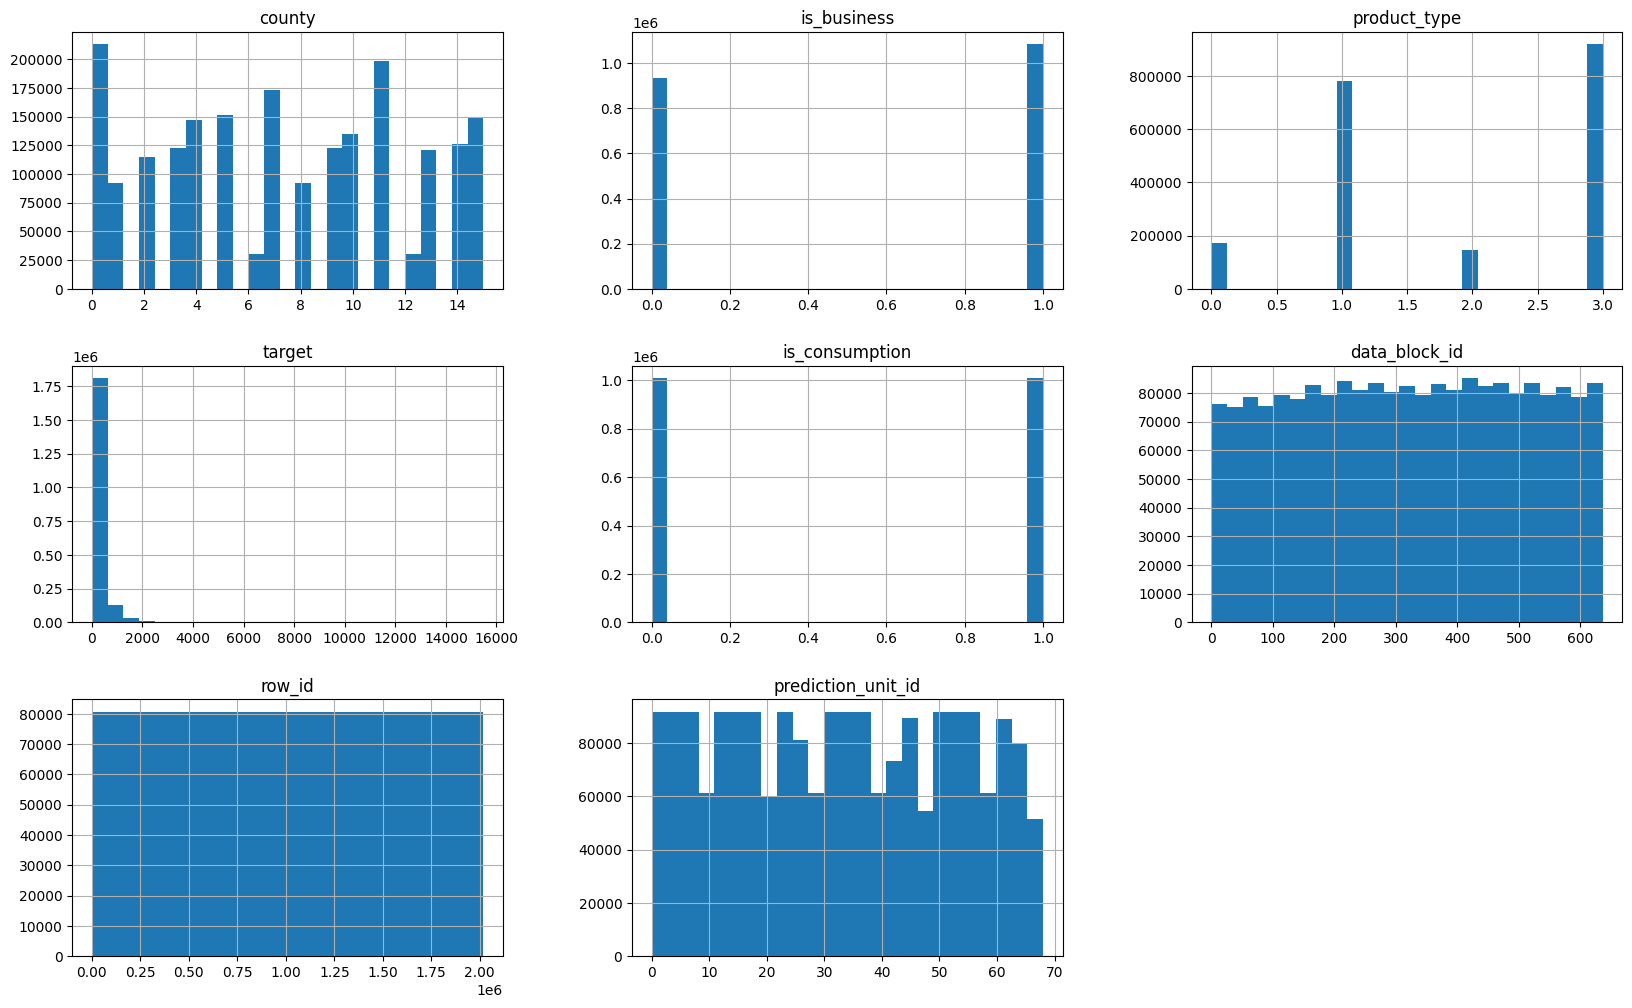

In [ ]:
num_attributes.hist(figsize=(20,12), bins=25);

## 4.2 - Bivariate Analysis

### H1 - Example
**FALSE** or **TRUE** - Explanation

In [ ]:
df4['county'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

## 4.3 - Multivariate Analysis

### 4.3.1 - Numerical Attributes

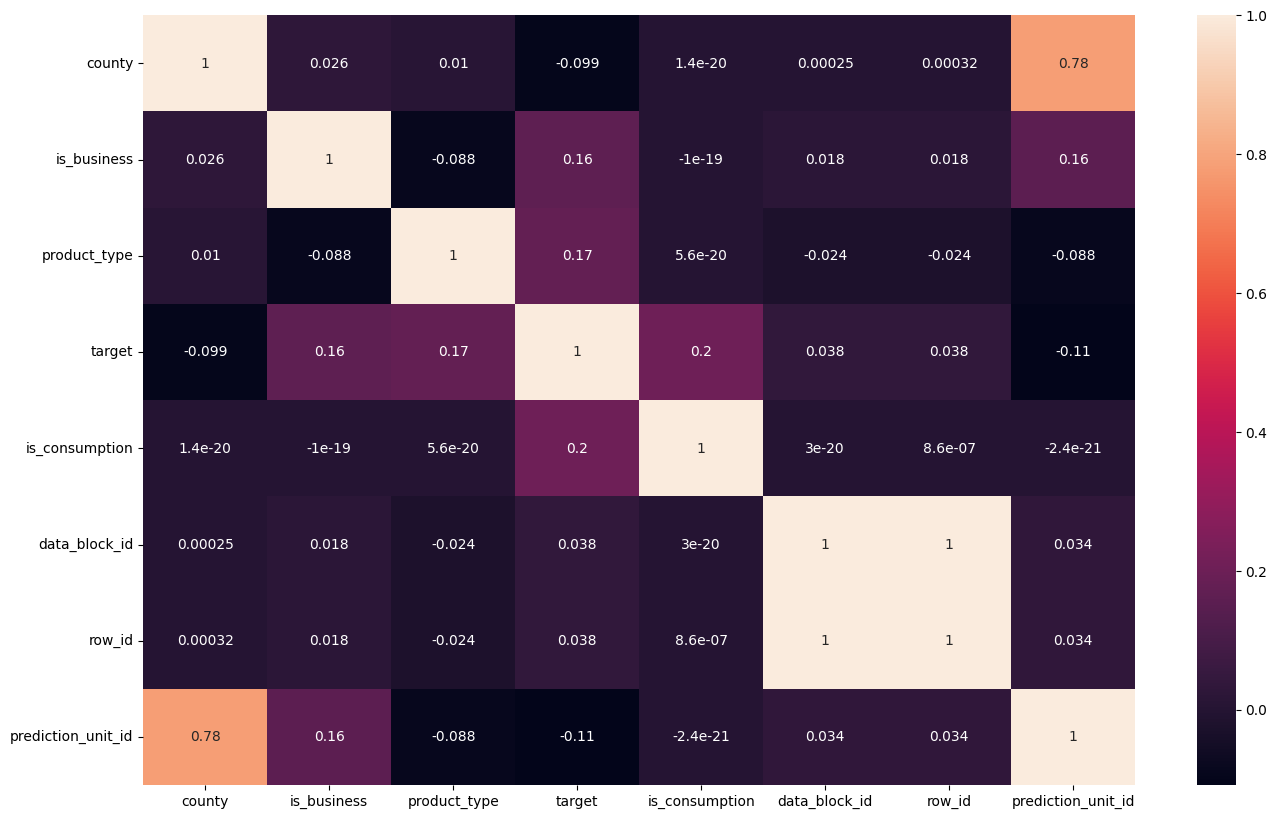

In [43]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(16,10))
sns.heatmap(correlation, annot=True);

### 4.3.2 - Caterogical Attributes

In [ ]:
a = df4.select_dtypes( include='object' )
a

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )
cramer_v(a['<cols>'])


## 4.4 - Resumo das Hipoteses

In [ ]:
tab =[
['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Verdadeira', 'Alta']
]
print( tabulate( tab, headers='firstrow' ) )

# 5.0 DATA PREPARATION

In [ ]:
df5 = df4.copy()

## 5.1 - Normalizacao

## 5.2 - Rescaling

In [ ]:
plt.figure(figsize=(16,10))
sns.boxplot(y=df5['<var>']);

In [ ]:
dir_parameter = 'src/parameter/'

# Example RobustScaler
rs = RobustScaler()
df5['<var>'] = rs.fit_transform( df5[['<var>']].values )
pickle.dump( rs, open(dir_parameter + '<archive>.pkl', 'wb') )

# Example MinMaxScaler
mms = MinMaxScaler()
df5['<var>'] = mms.fit_transform( df5[['<var>']].values )
pickle.dump( mms, open(dir_parameter + '<archive>.pkl', 'wb') )

## 5.3 - Transformacao

### 5.3.1 - Encoding

In [ ]:
dir_parameter = 'src/parameter/'

# Example One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['<var>'], columns=['<var>'] )

# Example Label Encoding
le = LabelEncoder()
df5['<var>'] = le.fit_transform( df5['<var>'] )
pickle.dump( le, open(dir_parameter + '<archive>.pkl', 'wb') )

# Example Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extented': 3}
df5['<var>'] = df5['<var>'].map( assortment_dict )

### 5.3.2 - Response Variable Transformation

In [ ]:
# Example
df5['<var>'] = np.log1p( df5['<var>'] )

plt.figure(figsize=(16,10))
sns.distplot(df5['<var>'])

### 5.3.3 - Nature Transformation

In [ ]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 FEATURE SELECTION

In [ ]:
df6 = df5.copy()

cols_drop = []
df6.drop(cols_drop, axis=1, inplace=True)

## 6.1 - Split Dataframe into training and test dataset

In [ ]:
X = df6.drop('<var>', axis=1)
Y = df6['<var>']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2 ,random_state=42)

# 7.0 MACHINE LEARNING MODELLING

## 7.1 Example Model

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

### 7.1.1 Example Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

# 8.0 HYPERPARAMETER FINE TUNING

# 9.0 TRANSLATE AND INTERPRETATION ERROR

## 9.1 Business Performance

## 9.2 Total Performance

## 9.3 Macinhe Learning Performance